# Doosan's 6DOF robotic arm example
This example demonstrate a simple robotic arm operation scenario.
We simulating an operation room with a robotic arm which suppose to locate some tool on a patient back. 

The setpoints on the patient back decided by a camera mounted on the tip. 

In general, the system can be described by the following diagram:

![](https://user-images.githubusercontent.com/58637596/212657304-a5810ce0-6d53-4421-ad43-e95a53379965.png)


We want to test the arm trajectories based on normal distributed tip setpoints:

$$ x_{est} =  normal(x_{true}, \sigma) $$
$$ y_{est} =  normal(y_{true}, \sigma) $$
$$ z_{est} =  normal(z_{true}, \sigma) $$

The 6DOF control is based on [ros2-control](https://control.ros.org/master/index.html) library and includes both joints control and trajectory controller.

This file contains both markdown cell for verbal explanations and python cells for analyzing the results.

Importing necessary packages

In [35]:
import json
import pymongo
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from bson.objectid import ObjectId
import warnings
import numpy as np
from collections import defaultdict
warnings.filterwarnings("ignore")

GREEN = '\033[92m'
FAIL = '\033[91m'
BLUE = '\033[94m'
WARNING = '\033[93m'
ENDC = '\033[0m'

%matplotlib inline

Define the minimum height for the tip:

In [22]:
MIN_HEIGHT = 1.0

Get the data from MongoDB:

In [7]:
def extract_tip_position(id):
    client = pymongo.MongoClient('mongodb://localhost:27017/')
    data = client['test_data'][id].aggregate([
        {
            '$match': {
                'topic_name': '/gazebo/link_states'
            }
        }, {
            '$project': {
                'data': {
                    '$arrayElemAt': [
                        '$data.pose', 8
                    ]
                }, 
                'id': '$id', 
                'simulation_run_id': '$simulation_run_id'
            }
        }, {
            '$project': {
                'id': '$id', 
                'pose': '$data.position', 
                'simulation_run_id': '$simulation_run_id'
            }
        }
    ])
    return list(data)

    
def create_time_vector(length):
    return np.linspace(0, 5, length)

Extract the tip position from the Database:

In [8]:
col_id = "1"
tip_positions_data = extract_tip_position(col_id)

x = defaultdict(list)
y = defaultdict(list)
z = defaultdict(list)

n_of_runs = max([run["simulation_run_id"] for run in tip_positions_data])

for element in tip_positions_data:
    x[element["simulation_run_id"]].append(element["pose"]["x"])
    y[element["simulation_run_id"]].append(element["pose"]["y"])
    z[element["simulation_run_id"]].append(element["pose"]["z"])     

After Extracting the tip position, we can plot the trajectory:

Text(0.5, 0, 'y [m]')

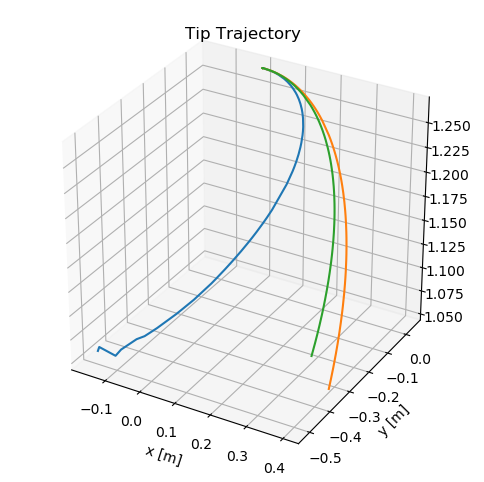

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

for i in range(int(n_of_runs)):
    ax.plot(x[str(i+1)], y[str(i+1)], z[str(i+1)])
plt.title("Tip Trajectory")
plt.xlabel("x [m]")
plt.ylabel("y [m]")



And we can also plot each axis vs. time:

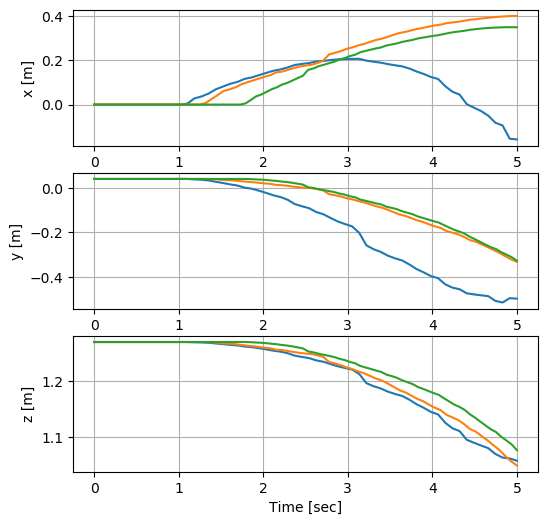

In [14]:
fig = plt.figure(figsize=(6, 6))
axx = fig.add_subplot(3,1,1)
axy = fig.add_subplot(3,1,2)
axz = fig.add_subplot(3,1,3)
for i in range(int(n_of_runs)):
    t = create_time_vector(len(x[str(i+1)]))
    axx.plot(t, x[str(i+1)])
    axy.plot(t, y[str(i+1)])
    axz.plot(t, z[str(i+1)])

axx.set_ylabel('x [m]')
axx.grid()


axy.set_ylabel('y [m]')
axy.grid()


axz.set_ylabel('z [m]')
axz.set_xlabel('Time [sec]')
axz.grid()


For safety reasons, we want to check that the tip position doesn't gets below `1[m]`:

In [38]:
height_crossing = 0
failed_runs = 0
for i in range(int(n_of_runs)):
    height_crossing = [1 for height in z[str(i+1)] if height < MIN_HEIGHT] 

    print(f"{GREEN}Run {i+1} passed{ENDC}") if not height_crossing else print(f"{FAIL}Run {i+1} failed{ENDC}") 

    if height_crossing:
        failed_runs += height_crossing

print(f"{BLUE}\n\nTotal runs: {n_of_runs}{ENDC}\n")
print(f"{GREEN}Number of successful tests: {int(n_of_runs) - failed_runs}{ENDC}")
print(f"{FAIL}Number of failed tests: {failed_runs}{ENDC}")

Run 1 passed
Run 2 passed
Run 3 passed


Total runs: 3

Number of successful tests: 3
Number of failed tests: 0
